In [106]:
import requests
import pandas as pd
import lxml.html as lh
from bs4 import BeautifulSoup as soup
import numpy as np 
import re
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
from matplotlib.widgets import RadioButtons

%matplotlib notebook
from matplotlib import pyplot as plt 
import seaborn as sns

# PROJECT DESCRIPTION
As I am currently living in Japan, I want to explore the temperature trend of Tokyo, Japan's capital.
Also, I have always been curious about the difference in temperature between Japan's East Coast ("Kanto" in Japanese, where Tokyo is), and West Coast ("Kansai" in Japanese). I chose Kyoto as the representative for West Coast, since it's one of the biggest cities in that region, and is also one of my favorite locations in Japan.

Fortunately, I found out that Japan has a very comprehensive database of temperatures from stations across the country, niceky formatted as table, and go back quite far to the late 19th century (astonishingly!). So it's not very difficult to retrieve the data, turn it into dataframes, and start tinkering! The details for the steps taken will be written down below.


## STEP 1: Data ingestion & cleaning
For data ingestion, I use the **request** library, the basics for all webscraping tasks in python, to retrieve the raw html.
I then use **BeautifulSoup** to parse the data and get it in a nested list format for DataFrame-ification.  
Since there is some mismatch in periods with measurement for Tokyo and Kyoto, with Tokyo having more data, I use the Kyoto data periods as base to filter the Tokyo data, and get 2 same-sized dataframe ready for exploration.  
Also, there are some weird symbols to denote level of confidence in the temperature of measurement, but we don't need to care too much about that for the purpose of this analysis, and nothing a little bit of **regex** cannot solve :D


*Note*: Just for fun, I also included the dataset for Asahikawa, another big Japanese city in the northern region of Hokkaido.
While it may not reveal any trend not seen in the Tokyo-Kyoto comparison, for those curious to see the trend for 2 cities in very different climate, it might be interesting to try. Using it is as simple as un-commenting the comments, and substituting asahikawa for kyoto in all the functions (remember to also change the city names where needed!).

In [107]:
url_tokyo = 'https://www.data.jma.go.jp/obd/stats/etrn/view/monthly_s3_en.php?block_no=47662&view=1'
url_kyoto = 'https://www.data.jma.go.jp/obd/stats/etrn/view/monthly_s3_en.php?block_no=47759&view=1'
# url_asahikawa = 'https://www.data.jma.go.jp/obd/stats/etrn/view/monthly_s3_en.php?block_no=47407&view=1'

def scrape_table(url):
    page = requests.get(url)
    content = soup(page.text, "html.parser")
    doc = lh.fromstring(page.content)
    table = doc.xpath("//tr")
    table = table[2:]
    data = [[0 for x in range(len(table[0]))] for y in range(len(table))]

    for row, line in enumerate(table):
        for col, val in enumerate(line):
            text = val.text_content()
            if re.findall("\s[])*]", text) != []:
                text = text.replace(re.findall("\s[])*]", text)[0], "")
            if text in ["-", " ", "", "\u3000", "×"]:
                text = np.nan
            data[row][col] = text

    df = pd.DataFrame(data)
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    df.set_index("Year", inplace=True)
    df.index = df.index.astype(np.int64)
    for col in df.columns:
        df[col] = df[col].astype(np.float64)
    return df

tokyo = scrape_table(url_tokyo)
kyoto = scrape_table(url_kyoto)
# asahikawa = scrape_table(url_asahikawa)

tokyo = tokyo.loc[kyoto.index]
# tokyo2 = tokyo.loc[asahikawa.index]

tokyo = tokyo.iloc[1:(tokyo.shape[0]-1)] #remove NaN rows
# tokyo2 = tokyo2.iloc[1:(tokyo2.shape[0]-1)]
kyoto = kyoto.iloc[1:(tokyo.shape[0]-1)] #remove NaN rows

cities = {"Tokyo":tokyo, "Kyoto":kyoto}

## STEP 2: Preparation and graphing
Since I want to see the trend by season, or at least by quarter, instead of just the whole year, I decided to split the months' measurement equally into 4 quarters.  
Also, after consulting some common temperature trend charts, I found that there are 2 common types, and also the 2 I like the most: a combo-chart of yearly averages and x-year rolling averages, and a change trend chart as compared to average of a specific period. Por que no los dos, right? So I decided to just make both! **GridSpec** comes in very handy here, as I can specify exactly how I want the subplots to be arranged. I just make the axes for both the running avg graphs (left), and for the running change graph (right).  
*Note: for some strange reason, the first time I ran the code below, the graphs stayed nicely in view, but ever since, it has become oversized. One might suspect the reason to be the figsize, but I had it set the first time as well. And if I didn't include the figsize, the graph becomes crunched together, and texts will be overlapping like crazy. So unfortunately you will have to make do with some scrolling. If anyone who reads my code knows why the graph overflows, and what I can do to keep everything nice and tight, please let me know, much appreciated!

I also decided to make it easy for myself by turning everything into a function, and parameterize everything possible. One function for the rolling graph - which contains the function for the x-year rolling average, and one function for the rolling change graph. This comes very handy for when I want to add any interactivity to the graphs (explained in the next step).  

I also have the (supposedly) bright idea to try and visualize the fluctuation range for the yearly quarter-average temps, to see if in addition to any trend, the colds are getting colder and hots getting hotter. I try to do this by identifying max and min temps for rolling x-year periods (I chose 20 in this case for reasonable coarseness), and graphing them as line plots alongside the running quarter-averages.  
While it may not be the most exact method, it certainly shows some interesting insights, mainly that the fluctuation band really seems to be wider for Q3 over time, for both Tokyo and Kyoto.  

For the running change graph, I overlap the Tokyo and Kyoto trend (with Tokyo being highlighted by default), and used the 1960-1980 period as baseline, since it seems the most stable, and also rather in the middle of the available data. Some trickery was used to achieve the effect of grey bars for negative changes and red for positive (quite proud of the trick!). Overall, it shows a clearer picture of the change, and also provides some clear comparison between the changes of Tokyo and Kyoto temperatures.


## STEP 3: Add some interactive pizzazz!
Why not, right? Since we have 2 data sets, and quite a lot to show, it stands to reason that some highlighting might be preferrable to aid in understandability. So I just added a simple radio button to highlight either Tokyo or Kyoto. This is also quite useful for the change graph, where you can see either the trend for Tokyo or Kyoto as the main focus, with the other's trend staying in the background for some comparison.    
The changing of alphas for the highlight, while looking like a simple trick, actually suprisingly took me some time and some brain-wringing to figure out! So also quite proud of that one.  

And with all of that out of the way, please enjoy the graph!

<IPython.core.display.Javascript object>


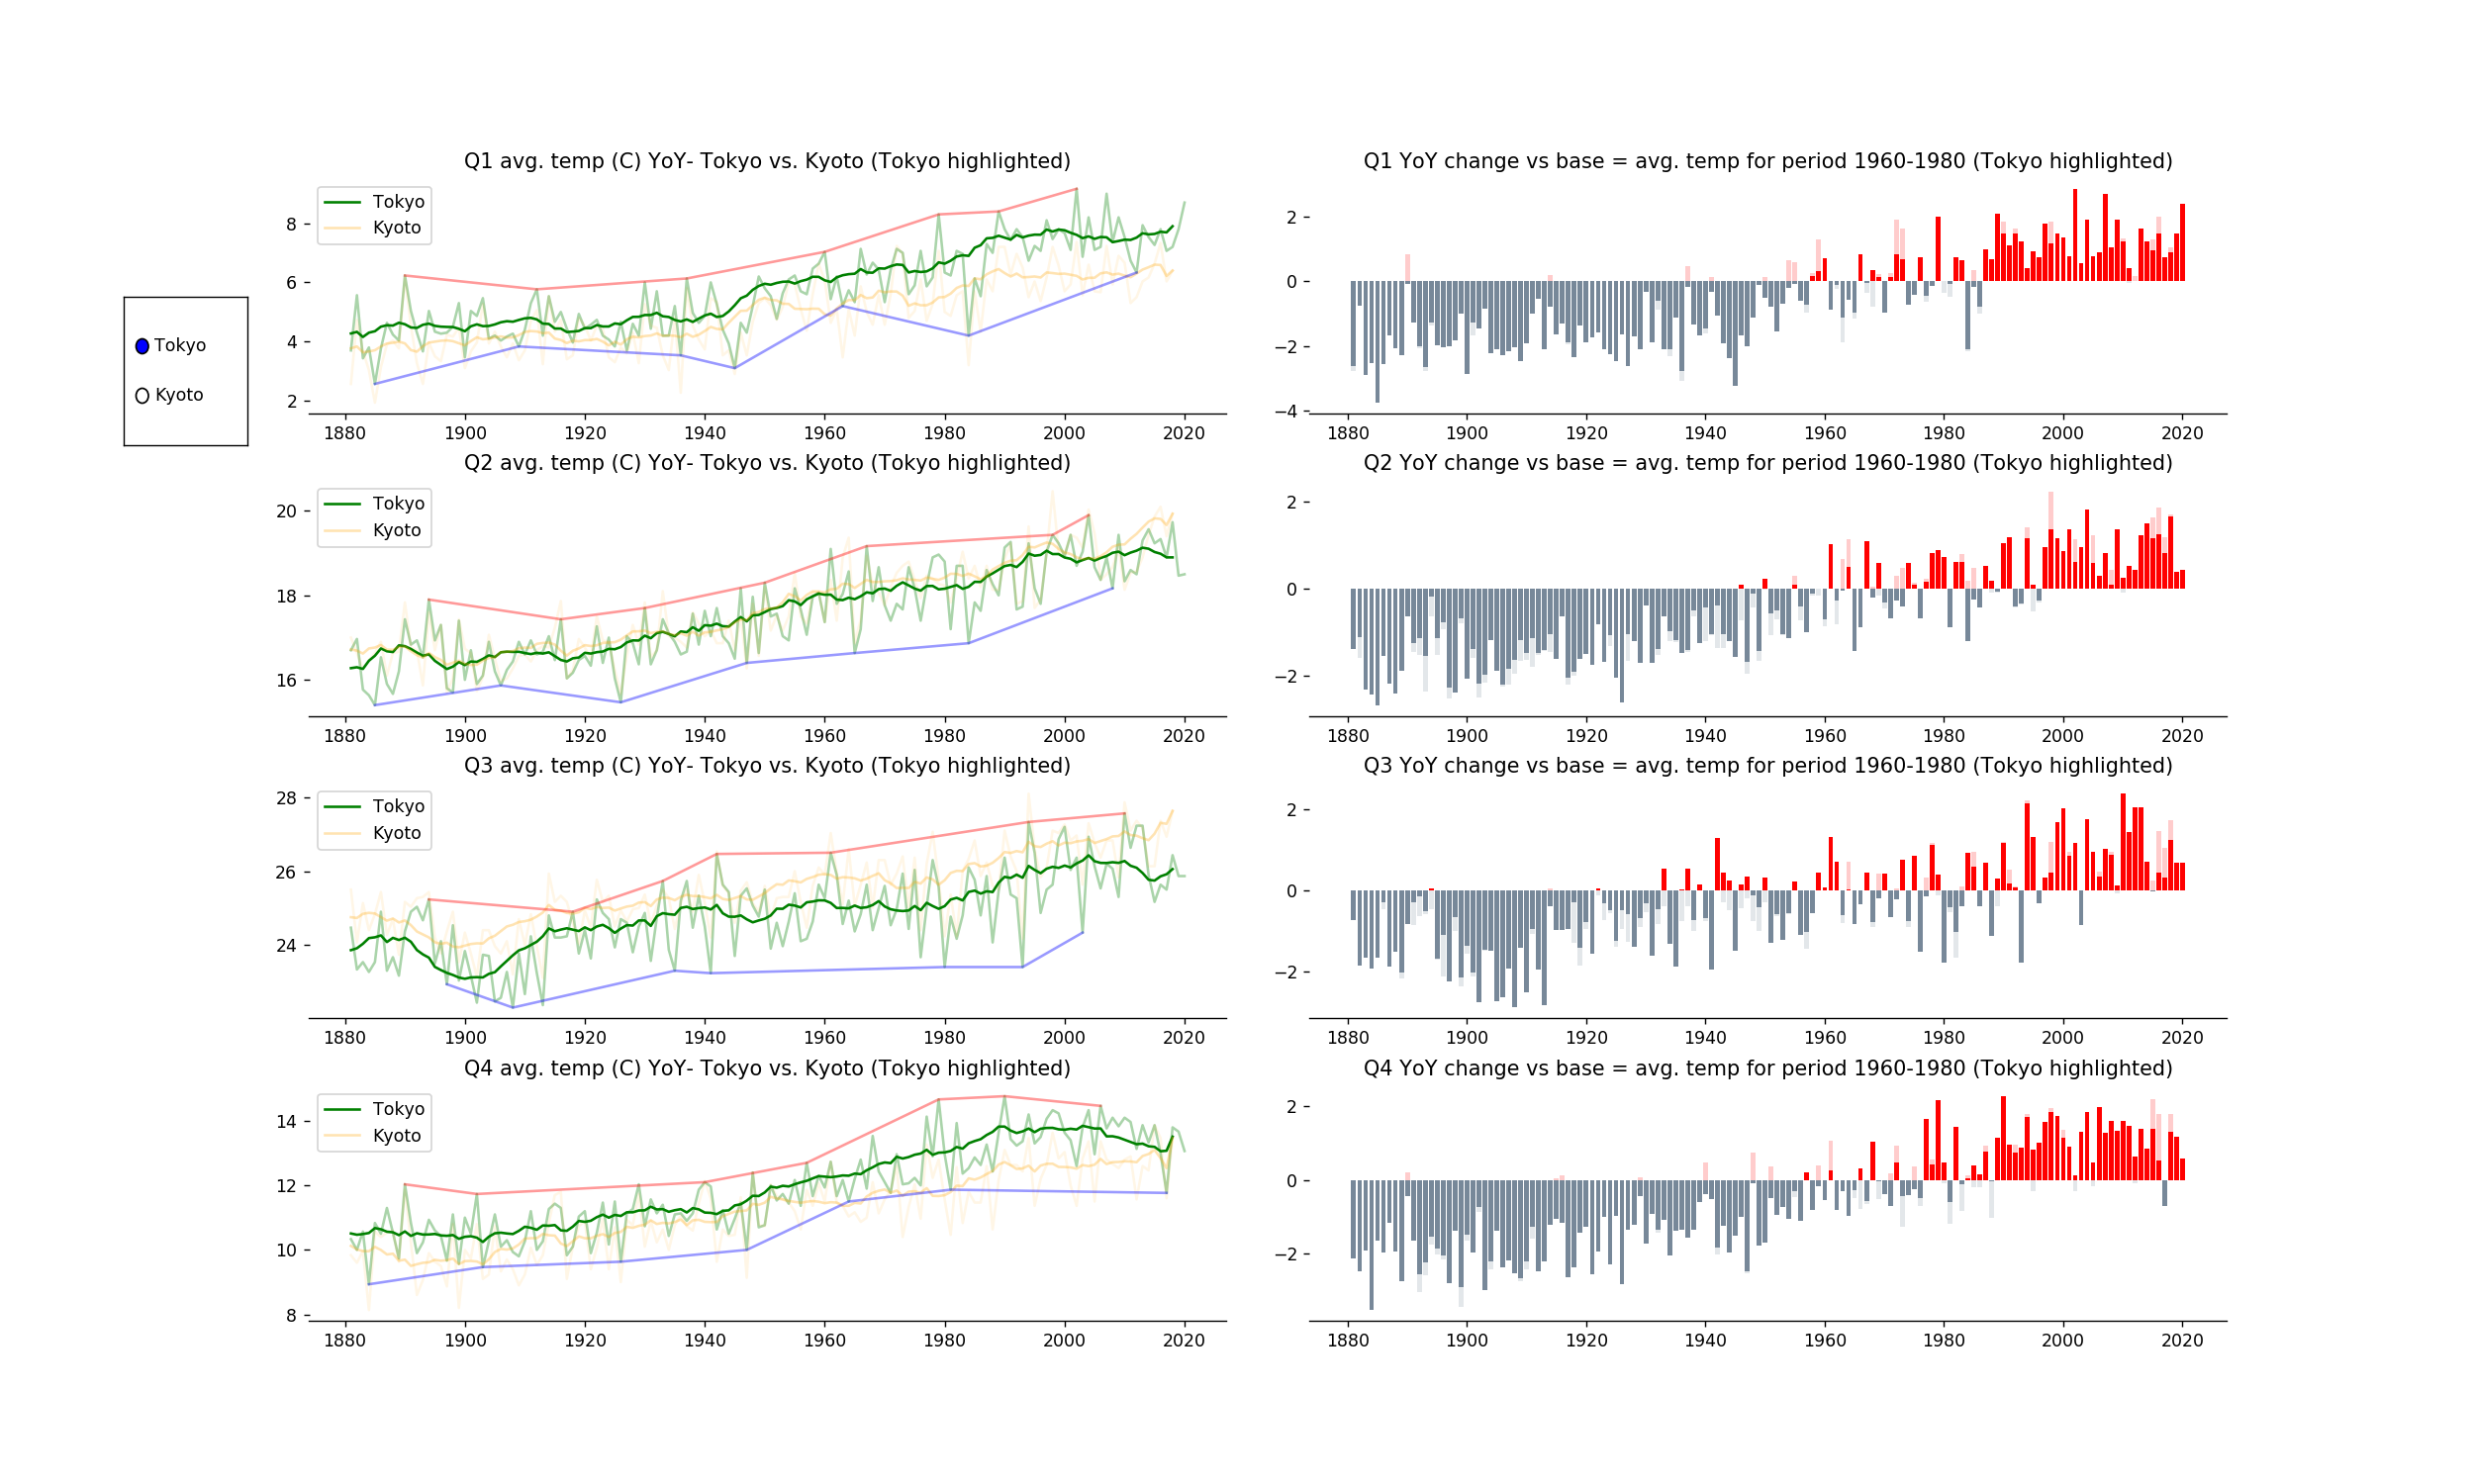

C:\Users\vuanh\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
C:\Users\vuanh\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


In [109]:
q1 = ["Jan", "Feb", "Mar"]
q2 = ["Apr", "May", "Jun"]
q3 = ["Jul", "Aug", "Sep"]
q4 = ["Oct", "Nov", "Dec"]
qs = [q1,q2,q3,q4]

fig = plt.figure(figsize=(20,12))
grid = GridSpec(8,4, hspace=0.8)

ax_q4 = plt.subplot(grid[6:8, :2])
ax_q1 = plt.subplot(grid[:2,:2], sharex=ax_q4)
ax_q2 = plt.subplot(grid[2:4, :2], sharex=ax_q4)
ax_q3 = plt.subplot(grid[4:6, :2], sharex=ax_q4)
ax_qs = (ax_q1, ax_q2, ax_q3, ax_q4)

ax_roll1 = plt.subplot(grid[0:2, 2:])
ax_roll2 = plt.subplot(grid[2:4, 2:], sharex=ax_roll1)
ax_roll3 = plt.subplot(grid[4:6, 2:], sharex=ax_roll1)
ax_roll4 = plt.subplot(grid[6:8, 2:], sharex=ax_roll1)

ax_rolls = (ax_roll1, ax_roll2, ax_roll3, ax_roll4) 

def draw_quarterly(axes, qs, city1_df, city2_df, city_names, highlighted, alpha_c1=1, alpha_c2=0.3):
    
    def rolling_agg(city_df, step=10, agg_func = np.mean):
        x = []
        y = []
        for i in kyoto.index:
            x.append(i)
            y.append(agg_func(city_df.loc[i:i+step]))
        return x,y

    for ind, (ax, q) in enumerate(zip(axes, qs)):
        city1_q = city1_df[q].apply(np.mean, axis=1)
        city2_q = city2_df[q].apply(np.mean, axis=1)
        city1_color = "green"
        city2_color = "orange"

        ax.plot(city1_df.index, city1_q, alpha=alpha_c1/3 , color=city1_color)
        ax.plot(city2_df.index, city2_q, alpha=alpha_c2/3, color=city2_color)

        city1_roll = rolling_agg(city1_q)
        city2_roll = rolling_agg(city2_q)

        ax.plot(city1_roll[0], city1_roll[1], label=city_names[0], color=city1_color, alpha=alpha_c1)
        ax.plot(city2_roll[0], city2_roll[1], label=city_names[1], color=city2_color, alpha=alpha_c2)
        
        ax.yaxis.set_major_locator(ticker.MultipleLocator(2))

        ax.set_title(f"Q{ind+1} avg. temp (C) YoY- {city_names[0]} vs. {city_names[1]} ({highlighted} highlighted)")
        ax.legend()


def draw_change_bar(city1_df, qs, axes, city_name, alpha=1, base_start=1960, base_end=1980):
    
    def neg_pos(df, start, end):
        x=[[],[]]
        y=[[],[]]

        base_range = [x for x in range(start,end)]
        base = df.loc[base_range].mean()

        for i in range(df.shape[0]):
            diff = df.iloc[i]-base
            if diff>=0:
                x[0].append(df.index[i])
                y[0].append(diff)
            else:
                x[1].append(df.index[i])
                y[1].append(diff)
        return x, y
    
    for ind, (ax, q) in enumerate(zip(axes,qs)):
        city1_q = city1_df[q].apply(np.mean, axis=1)
        city1_x, city1_y = neg_pos(city1_q, base_start, base_end)
        ax.bar(city1_x[0], city1_y[0], color="red", alpha=alpha)
        ax.bar(city1_x[1], city1_y[1], color="lightslategrey", alpha=alpha)
        ax.set_title(f'Q{ind+1} YoY change vs base = avg. temp for period {base_start}-{base_end} ({city_name} highlighted)')
        ax.yaxis.set_major_locator(ticker.MultipleLocator(2))


def draw_maxmin(city1_df, axes, qs, alpha=0.4, period=10):

    def maxmin(city_df):
        temp_maxmin = [[0 for i in range(round(city_df.shape[0]/period))] for i in range(4)]
        for ind, year in enumerate(range(city_df.index[0], city_df.index[-1]+1, period)):
            decade = [x for x in range(year, year+period)]
            temp_maxmin[0][ind] = city_df.loc[decade].argmax()
            temp_maxmin[1][ind] = city_df.loc[decade].max()
            temp_maxmin[2][ind] = city_df.loc[decade].argmin()
            temp_maxmin[3][ind] = city_df.loc[decade].min()
        return temp_maxmin
    
    for ind, (ax, q) in enumerate(zip(axes, qs)):
        city1_q = city1_df[q].apply(np.mean, axis=1)
        temp_maxmin = maxmin(city1_q)
        
        ax.plot(temp_maxmin[0], temp_maxmin[1], color="r", alpha=alpha)
        ax.plot(temp_maxmin[2], temp_maxmin[3], color="b", alpha=alpha)


draw_quarterly(ax_qs, qs, tokyo, kyoto, ["Tokyo", "Kyoto"], highlighted="Tokyo")
draw_change_bar(cities["Kyoto"], qs, ax_rolls, "Kyoto", alpha=0.2)
draw_change_bar(cities["Tokyo"], qs, ax_rolls, "Tokyo")
draw_maxmin(cities["Tokyo"], ax_qs, qs, period=20)


for ax_q, ax_roll in zip(ax_qs, ax_rolls):
    for pos in ["top", "right","left"]:
        ax_q.spines[pos].set_visible(False)
        ax_roll.spines[pos].set_visible(False)

radioax = plt.axes([0.05,0.7,0.05,0.1])
radio = RadioButtons(radioax, ["Tokyo", "Kyoto"])

def highlight(label):
    alphas = {"Tokyo":0.2, "Kyoto":0.2}
    for ax_q, ax_roll in zip(ax_qs, ax_rolls):
        ax_q.clear()
        ax_roll.clear()
    alphas[label]=1
    city1_name = label
    city2_name = [x for x in list(alphas.keys()) if x != label][0]
    draw_quarterly(ax_qs, qs, cities["Tokyo"], cities["Kyoto"], ["Tokyo", "Kyoto"], highlighted=label, alpha_c1=alphas["Tokyo"], alpha_c2=alphas["Kyoto"])
    draw_change_bar(cities[city1_name], qs, ax_rolls, city1_name, alpha=alphas[city1_name])
    draw_change_bar(cities[city2_name], qs, ax_rolls, city1_name, alpha=alphas[city2_name])
    draw_maxmin(cities[city1_name], ax_qs, qs, period=20)

    for ax_q, ax_roll in zip(ax_qs, ax_rolls):
        for pos in ["top", "right","left"]:
            ax_q.spines[pos].set_visible(False)
            ax_roll.spines[pos].set_visible(False)
    plt.draw()
radio.on_clicked(highlight)

plt.show()